In [ ]:
# ¿Can we predict a genre of a music album through inheritable interpretable (CW) modeling of its artwork (cover album)?

## Batch Normalization Model

### Data Loading  and Preprocessing

In [ ]:
# Importing libraries
import os
import random
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import keras

# Set matplotlib to inline mode
%matplotlib inline


In [ ]:
# Seed value definition
def set_seed(seed=42):
    """Set seed for reproducibility."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Call the function with the desired seed
set_seed(42)


In [ ]:
# Specify paths to the datasets
original_dataset_directory = "/content/drive/MyDrive/documentos/vinyl genre class/data/For thesis"
original_train_directory = os.path.join(original_dataset_directory, 'Training')


In [ ]:
# 0 for electronic, 1 for rock, 2 for hiphop
# Initialize lists to store genres and image files
genres = []
img_files= []

# List all files in the training directory
imgs = os.listdir(original_train_directory)

# Load training labels from CSV
training_lbls = pd.read_csv('/content/drive/MyDrive/documentos/vinyl genre class/data/For thesis/training_labels.csv')

# Loop through all labels and append corresponding genres and image files to the lists
for k in range(len(training_lbls)):
    for file in imgs:
        if file == training_lbls['name'][k]:
            genres.append(training_lbls['category'][k])
            img_files.append(file)

# Create a dataframe to map each image with its label
df = pd.DataFrame({'image': img_files,'category':genres})

# Display the first few rows of the dataframe
df.head(min(3000, len(df)))


image    category
0        image_1.jpeg  electronic
1        image_2.jpeg  electronic
2        image_3.jpeg  electronic
3        image_4.jpeg  electronic
4        image_5.jpeg  electronic
...               ...         ...
2455  image_3316.jpeg        rock
2456  image_3317.jpeg        rock
2457  image_3318.jpeg        rock
2458  image_3319.jpeg        rock
2459  image_3320.jpeg        rock

[2460 rows x 2 columns]

In [ ]:
# Define directories for train, test and validation datasets
base_dir = "./BatchNorm_split"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validate_dir = os.path.join(base_dir, 'validate')

# Create directories for train, test and validation datasets if they don't exist
for directory in [base_dir, train_dir, test_dir, validate_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)
        print(directory, "created")

# Define directories for each genre in train, test and validation datasets
subdirectories_electronic = []
subdirectories_rock = []
subdirectories_hiphop = []

# Create directories for each genre in train, test and validation datasets if they don't exist
for subdirectory in [train_dir, test_dir, validate_dir]:
    subdirectories_electronic.append(os.path.join(subdirectory,'electronic'))
    if not os.path.exists(os.path.join(subdirectory,'electronic')):
        os.mkdir(os.path.join(subdirectory,'electronic'))
        print(os.path.join(subdirectory,'electronic'),"created")

    subdirectories_rock.append(os.path.join(subdirectory, 'rock'))
    if not os.path.exists(os.path.join(subdirectory, 'rock')):
        os.mkdir(os.path.join(subdirectory, 'rock'))
        print(os.path.join(subdirectory, 'rock'), "created")

    subdirectories_hiphop.append(os.path.join(subdirectory,'hiphop'))
    if not os.path.exists(os.path.join(subdirectory,'hiphop')):
        os.mkdir(os.path.join(subdirectory,'hiphop'))
        print(os.path.join(subdirectory,'hiphop'),"created")


In [ ]:
# Split the data into train, test and validation sets
x_train, x_test1, y_train, y_test1 = train_test_split(df["image"], df["category"] ,test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test1, y_test1 ,test_size=0.5, random_state=42)

# Print the size of each set
print('Training data set size :', y_train.shape[0])
print('Test data set size :', y_test.shape[0])
print('Validation data set size :', y_val.shape[0])


Training data set size : 1968
Test data set size : 246
Validation data set size : 246


In [ ]:
# Copy the files into the corresponding genre directories in train, test and validation datasets
x = [x_train,x_test,x_val]
y = [y_train,y_test,y_val]
k = 0

for images,genres in zip(x,y) :
    for (file,category) in zip(images,genres):
        if category == 'electronic':
            src = os.path.join(original_train_directory, file)
            dst = os.path.join(subdirectories_electronic[k], file)
            shutil.copyfile(src, dst)
        elif category == 'rock':
            src = os.path.join(original_train_directory, file)
            dst = os.path.join(subdirectories_rock[k], file)
            shutil.copyfile(src, dst)
        else:
            src = os.path.join(original_train_directory, file)
            dst = os.path.join(subdirectories_hiphop[k], file)
            shutil.copyfile(src, dst)

    print(len(os.listdir(subdirectories_electronic[k])), " electronic covers copied to:", subdirectories_electronic[k])
    print(len(os.listdir(subdirectories_rock[k])), " rock covers copies to:", subdirectories_rock[k])
    print(len(os.listdir(subdirectories_hiphop[k])), " hiphop covers copied to:", subdirectories_hiphop[k])

    k = k + 1


739  electronic covers copied to: ./BatchNorm_split/train/electronic
747  rock covers copies to: ./BatchNorm_split/train/rock
737  hiphop covers copied to: ./BatchNorm_split/train/hiphop
139  electronic covers copied to: ./BatchNorm_split/test/electronic
149  rock covers copies to: ./BatchNorm_split/test/rock
132  hiphop covers copied to: ./BatchNorm_split/test/hiphop
139  electronic covers copied to: ./BatchNorm_split/validate/electronic
146  rock covers copies to: ./BatchNorm_split/validate/rock
137  hiphop covers copied to: ./BatchNorm_split/validate/hiphop


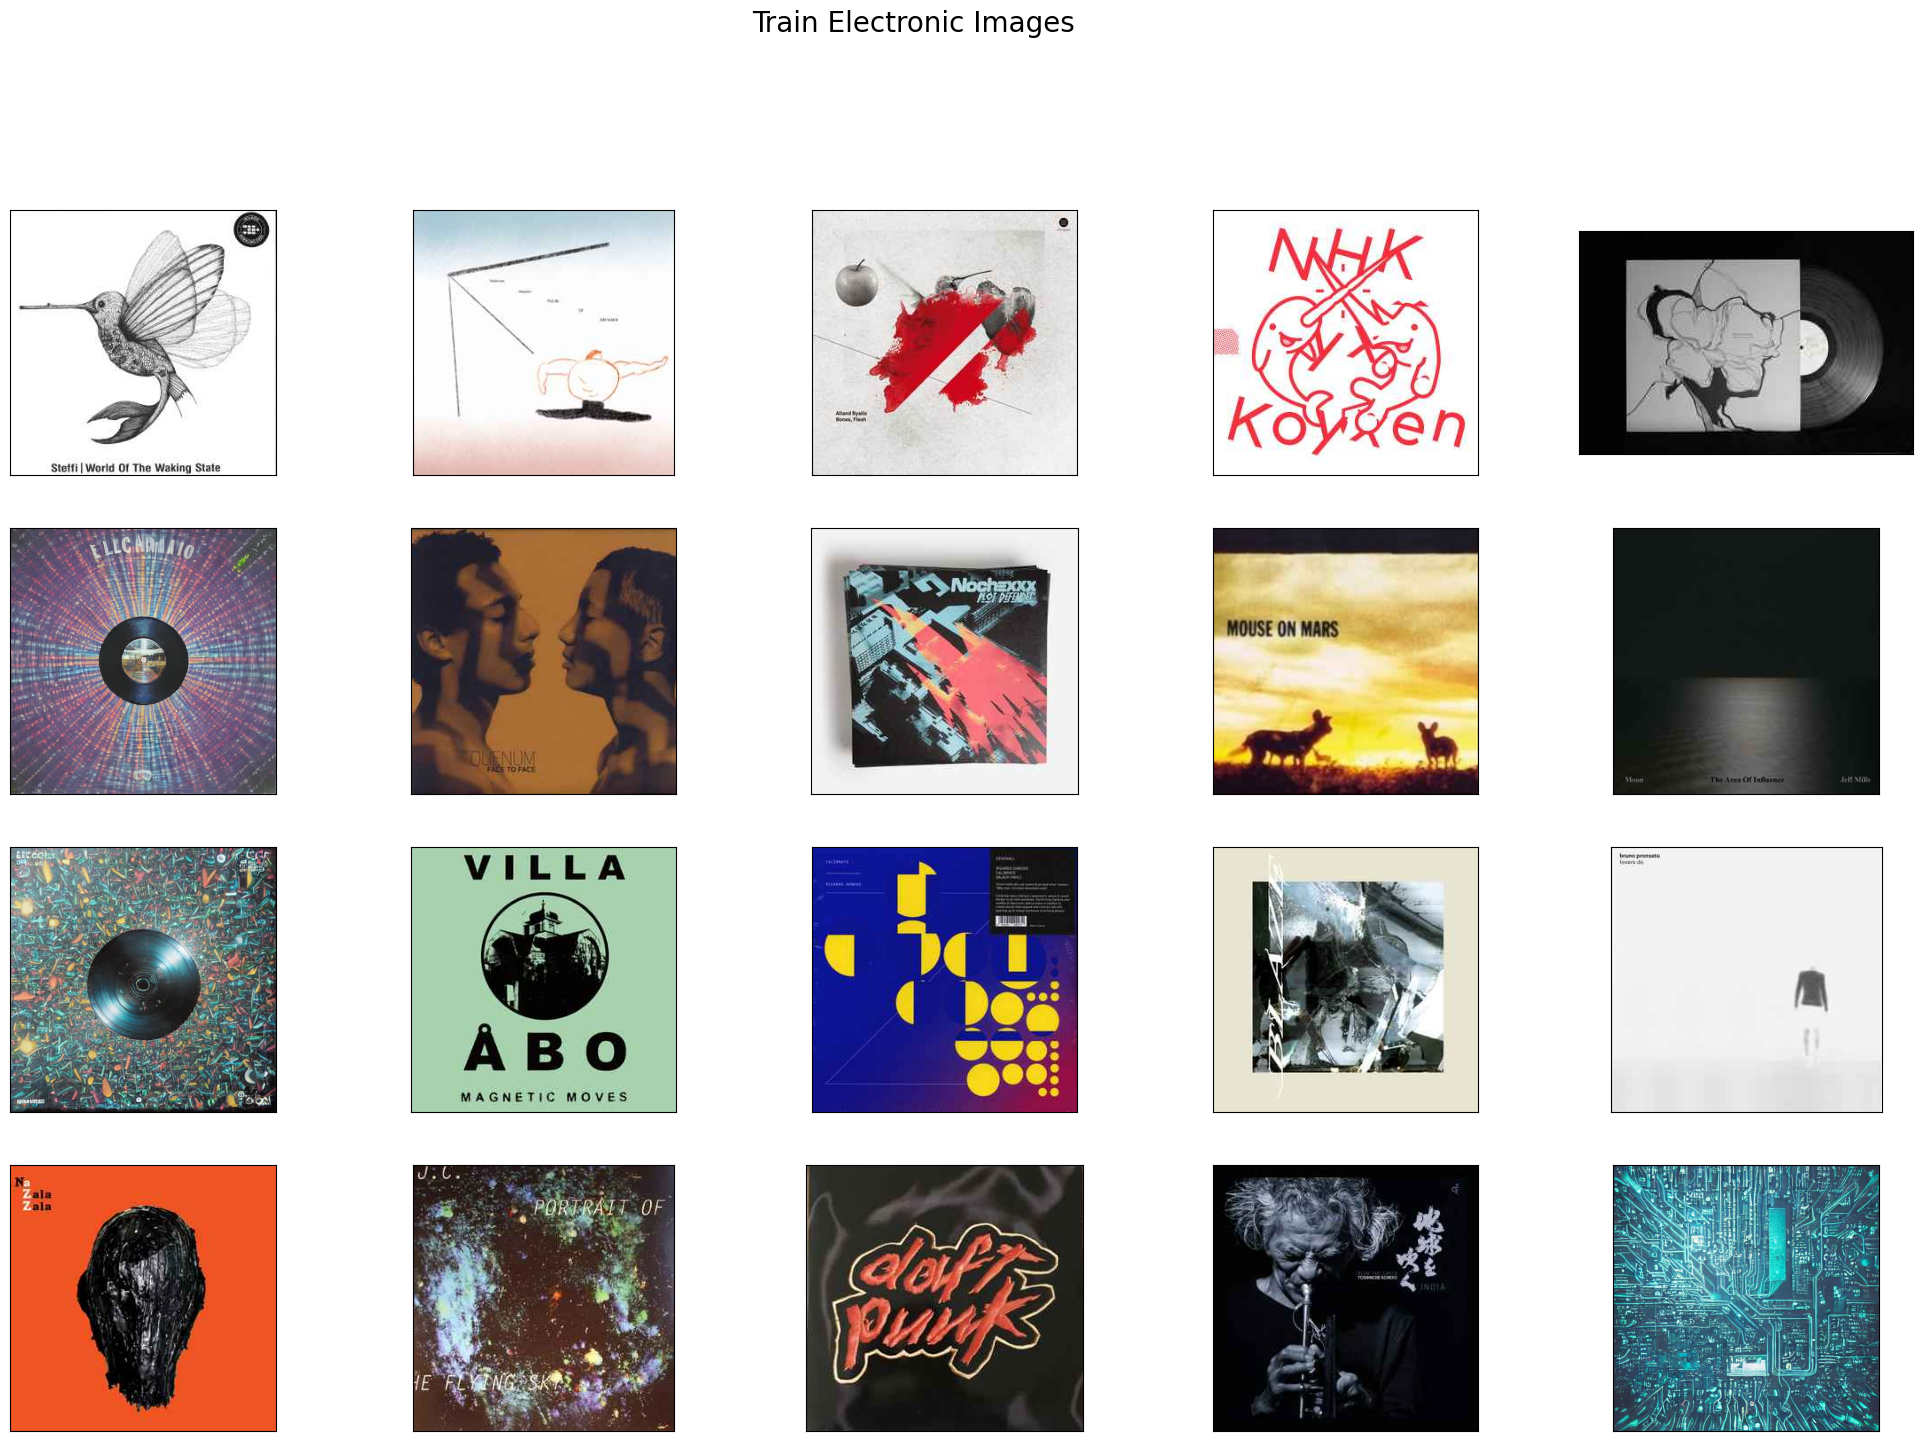

In [ ]:
# Visualize training electronic images examples
plt.figure(figsize=(25,20))
plt.suptitle("Train Electronic Images", fontsize=20)

images = os.listdir(subdirectories_electronic[0])
for i in range(len(images)-20, len(images)):
    plt.subplot(5,5,i-len(images)+20+1)

    full_image = plt.imread(os.path.join(original_train_directory, images[i]))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(full_image, cmap=plt.cm.binary)


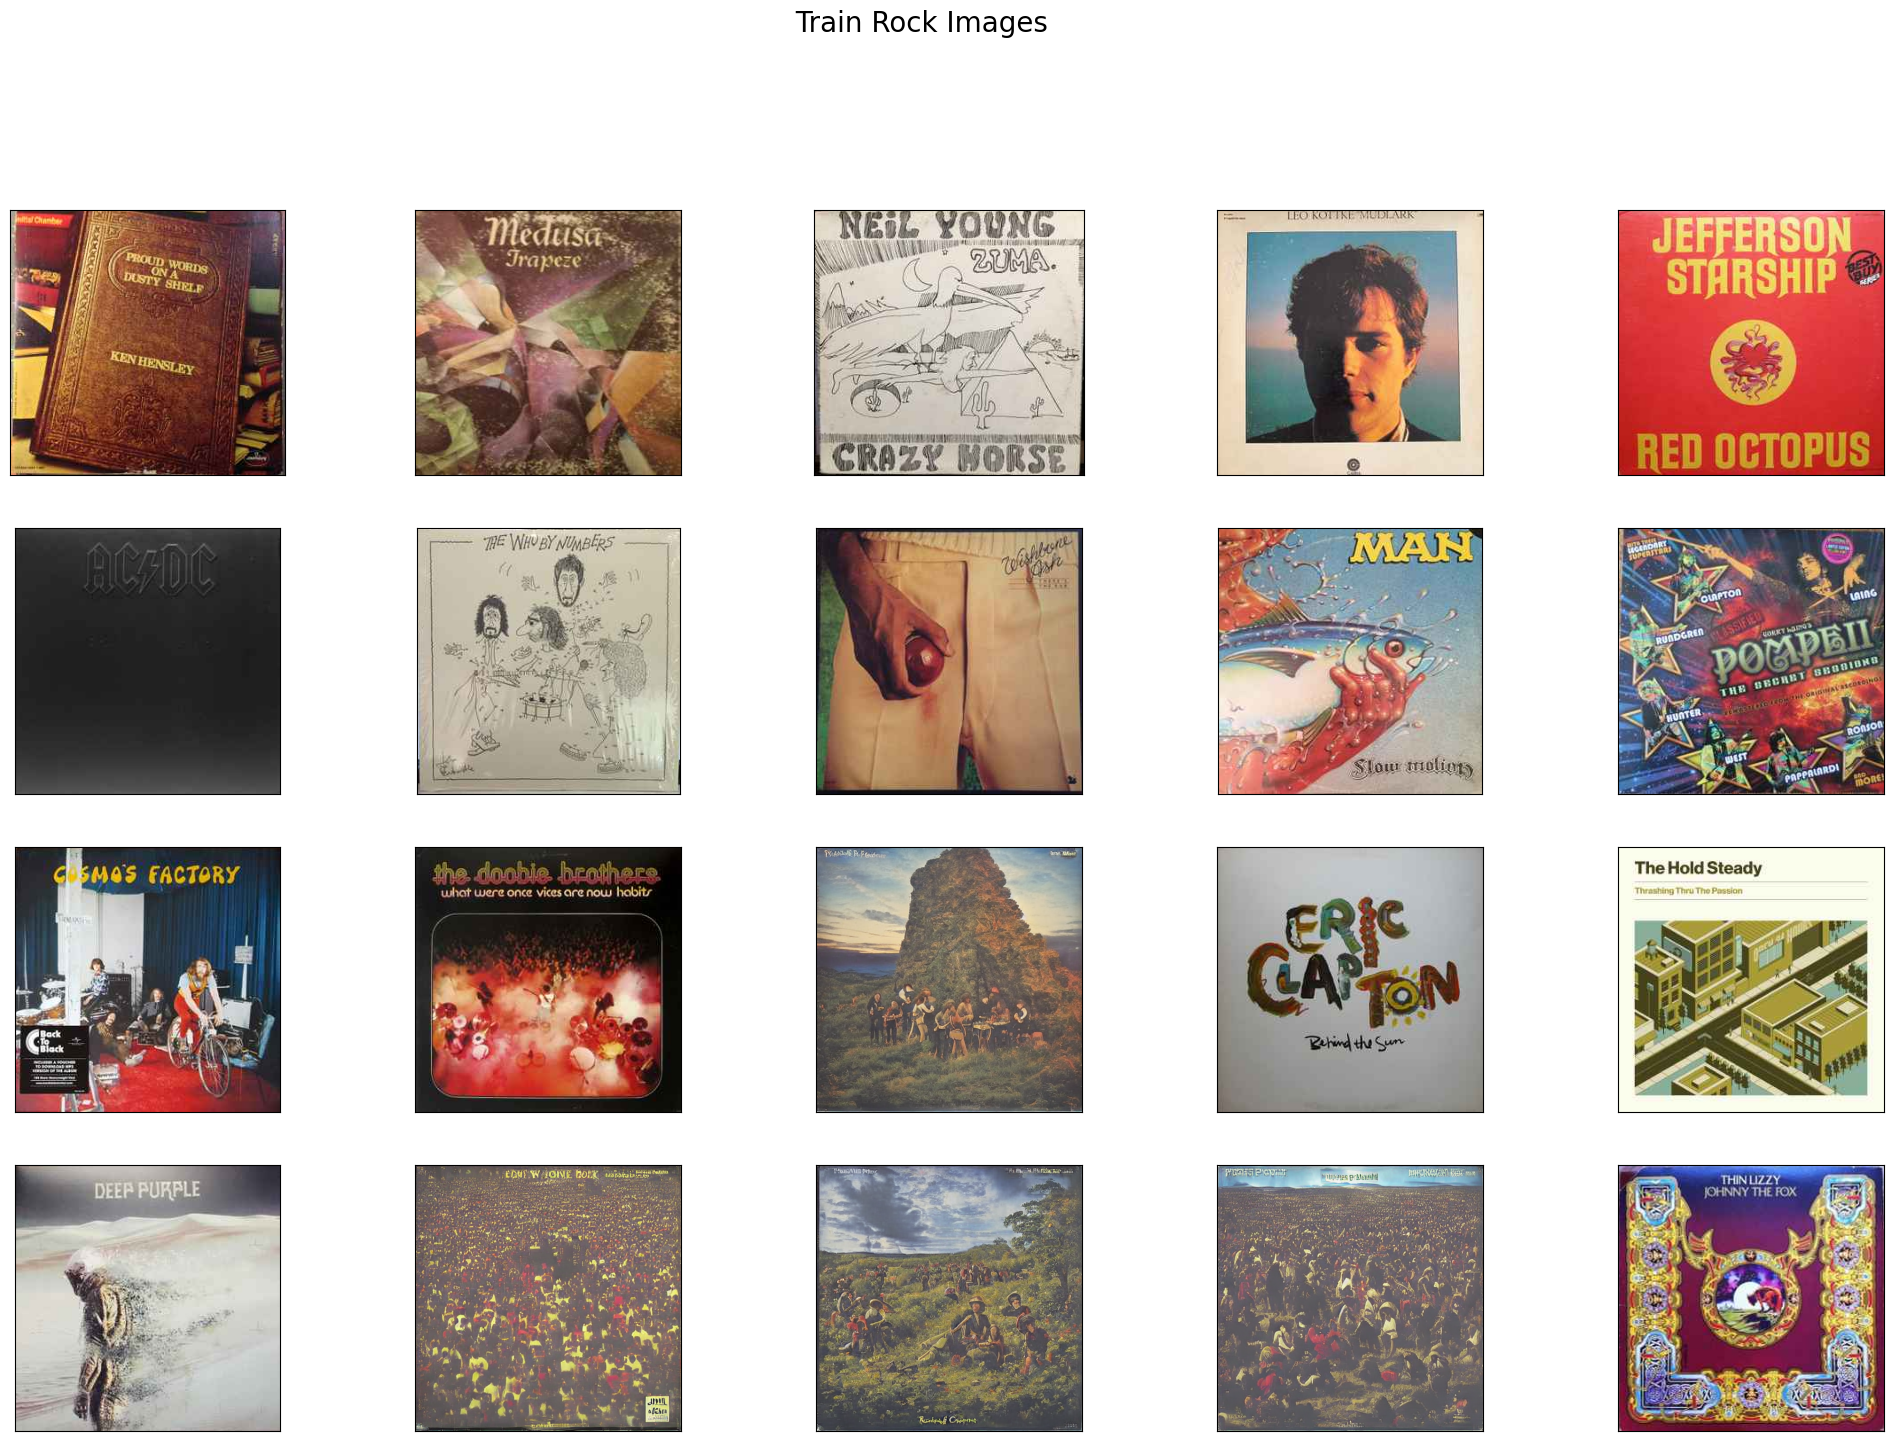

In [ ]:
# Visualize training rock images examples
plt.figure(figsize=(25,20))
plt.suptitle(" Train Rock Images", fontsize=20)

images = os.listdir(subdirectories_rock[0])
for i in range(len(images)-20, len(images)):
    plt.subplot(5,5,i-len(images)+20+1)

    full_image = plt.imread(os.path.join(original_train_directory, images[i]))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(full_image, cmap=plt.cm.binary)

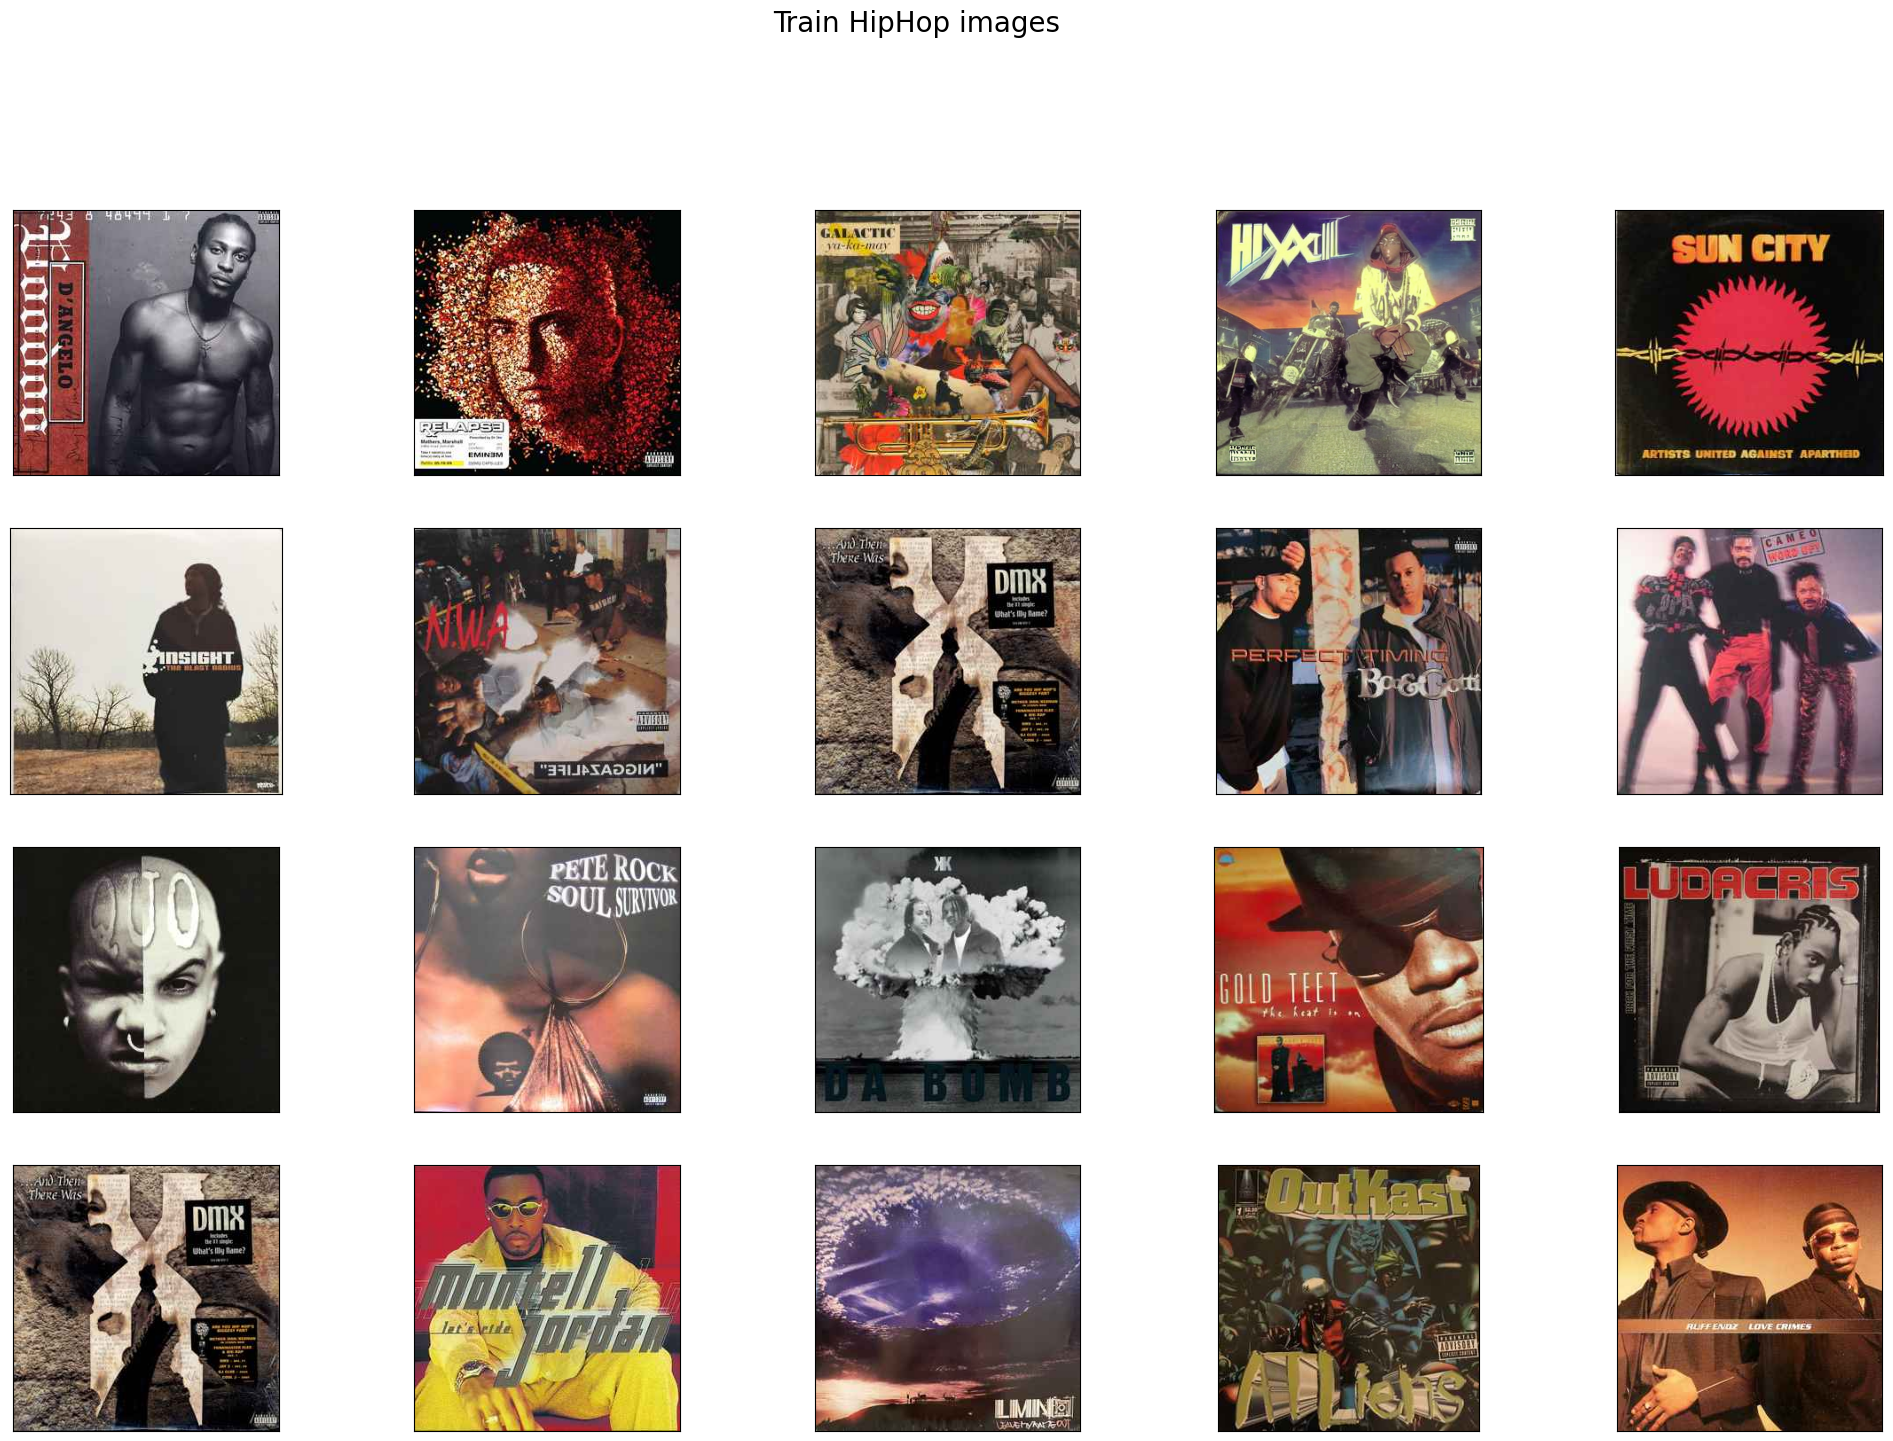

In [ ]:
# Visualize training hiphop images examples
plt.figure(figsize=(25,20))
plt.suptitle("Train HipHop images", fontsize=20)

images = os.listdir(subdirectories_hiphop[0])
for i in range(len(images)-20, len(images)):
    plt.subplot(5,5,i-len(images)+20+1)

    full_image = plt.imread(os.path.join(original_train_directory, images[i]))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(full_image, cmap=plt.cm.binary)

In [ ]:
# Create ImageDataGenerators for training and validation datasets
# ImageDataGenerators are used to generate batches of tensor image data with real-time data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define target size for resizing images and batch size
# Class mode is set to 'categorical' for multi-class classification
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(300,300),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validate_dir,
        target_size=(300,300),
        batch_size=20,
        class_mode='categorical')

# Print the shapes of data and labels batches to confirm they are as expected
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break


Found 2223 images belonging to 3 classes.
Found 422 images belonging to 3 classes.
data batch shape: (20, 300, 300, 3)
labels batch shape: (20, 3)


### Model Architecture

In [ ]:
# Import ResNet152v2 pre trained model with imagenet weights
from tensorflow.keras.applications import ResNet152V2

pre_trained_model = ResNet152V2(weights='imagenet', include_top = False, input_shape = (300,300,3))
pre_trained_model.summary()

In [ ]:
# Set all pre-trained model layers to be non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

# Define the custom neural network architecture
last_layer = pre_trained_model.get_layer('post_relu')
last_output = last_layer.output

# Add additional layers on top of the pre-trained model
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1(0.01))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.01))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

# Combine the pre-trained model with the additional layers to form the full model
bn_model = tf.keras.Model(pre_trained_model.input, x)
bn_model.summary()


### Training and Evaluation

In [ ]:
# Open trainable layers
pre_trained_model.trainable = True
set_trainable = False
for layer in pre_trained_model.layers:
    if layer.name == 'conv5_block3_preact_bn':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Define the learning rate scheduler function
def lr_scheduler(epoch):
    lr = 1e-4
    if epoch > 10:
        lr *= 0.1
    if epoch > 20:
        lr *= 0.1
    return lr

# Set up callback functions
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=1e-4)
checkpoint = ModelCheckpoint('bn_finetune.h16', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='max')

# Compile the model
bn_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = bn_model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=len(validation_generator),
      callbacks=[lr_reduce, checkpoint, early_stopping, lr_scheduler_callback])


Epoch 1/10


2023-09-01 15:14:25.716594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-09-01 15:14:30.318958: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 115200000 exceeds 10% of free system memory.
2023-09-01 15:14:30.387019: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 118292480 exceeds 10% of free system memory.
2023-09-01 15:14:30.442093: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 115200000 exceeds 10% of free system memory.
2023-09-01 15:14:30.472191: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 115200000 exceeds 10% of free system memory.
2023-09-01 15:14:30.498739: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 115200000 exceeds 1

112/112 [==============================] - ETA: 0s - loss: 308.7983 - accuracy: 0.4188

2023-09-01 15:18:24.794144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.65166, saving model to bn_finetune.h16


2023-09-01 15:19:15.269012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-09-01 15:19:15.277015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-09-01 15:19:15.284527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-09-01 15:19

INFO:tensorflow:Assets written to: bn_finetune.h16/assets


INFO:tensorflow:Assets written to: bn_finetune.h16/assets


112/112 [==============================] - 306s 3s/step - loss: 308.7983 - accuracy: 0.4188 - val_loss: 277.4361 - val_accuracy: 0.6517 - lr: 1.0000e-04
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 240.7612 - accuracy: 0.5569
Epoch 2: val_accuracy improved from 0.65166 to 0.76303, saving model to bn_finetune.h16


2023-09-01 15:24:18.576959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-09-01 15:24:18.586447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-09-01 15:24:18.593877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-09-01 15:24

INFO:tensorflow:Assets written to: bn_finetune.h16/assets


INFO:tensorflow:Assets written to: bn_finetune.h16/assets


112/112 [==============================] - 303s 3s/step - loss: 240.7612 - accuracy: 0.5569 - val_loss: 202.4476 - val_accuracy: 0.7630 - lr: 1.0000e-04
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 167.4440 - accuracy: 0.6802
Epoch 3: val_accuracy improved from 0.76303 to 0.85545, saving model to bn_finetune.h16


2023-09-01 15:29:28.433137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-09-01 15:29:28.441814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-09-01 15:29:28.449454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-09-01 15:29

INFO:tensorflow:Assets written to: bn_finetune.h16/assets


INFO:tensorflow:Assets written to: bn_finetune.h16/assets


112/112 [==============================] - 310s 3s/step - loss: 167.4440 - accuracy: 0.6802 - val_loss: 134.0233 - val_accuracy: 0.8555 - lr: 1.0000e-04
Epoch 4/10
112/112 [==============================] - ETA: 0s - loss: 107.3524 - accuracy: 0.7935
Epoch 4: val_accuracy improved from 0.85545 to 0.87915, saving model to bn_finetune.h16


2023-09-01 15:34:34.760201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-09-01 15:34:34.769597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-09-01 15:34:34.777106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-09-01 15:34

INFO:tensorflow:Assets written to: bn_finetune.h16/assets


INFO:tensorflow:Assets written to: bn_finetune.h16/assets


112/112 [==============================] - 307s 3s/step - loss: 107.3524 - accuracy: 0.7935 - val_loss: 83.6770 - val_accuracy: 0.8791 - lr: 1.0000e-04
Epoch 5/10
112/112 [==============================] - ETA: 0s - loss: 65.8225 - accuracy: 0.8731
Epoch 5: val_accuracy improved from 0.87915 to 0.90047, saving model to bn_finetune.h16


2023-09-01 15:39:54.898126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-09-01 15:39:54.907821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-09-01 15:39:54.915562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-09-01 15:40

INFO:tensorflow:Assets written to: bn_finetune.h16/assets


INFO:tensorflow:Assets written to: bn_finetune.h16/assets


112/112 [==============================] - 320s 3s/step - loss: 65.8225 - accuracy: 0.8731 - val_loss: 50.9318 - val_accuracy: 0.9005 - lr: 1.0000e-04
Epoch 6/10
112/112 [==============================] - ETA: 0s - loss: 40.0495 - accuracy: 0.9303
Epoch 6: val_accuracy improved from 0.90047 to 0.90521, saving model to bn_finetune.h16


2023-09-01 15:45:04.846874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-09-01 15:45:04.855362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-09-01 15:45:04.862955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-09-01 15:45

INFO:tensorflow:Assets written to: bn_finetune.h16/assets


INFO:tensorflow:Assets written to: bn_finetune.h16/assets


112/112 [==============================] - 309s 3s/step - loss: 40.0495 - accuracy: 0.9303 - val_loss: 30.9720 - val_accuracy: 0.9052 - lr: 1.0000e-04
Epoch 7/10
112/112 [==============================] - ETA: 0s - loss: 24.4415 - accuracy: 0.9528
Epoch 7: val_accuracy improved from 0.90521 to 0.91232, saving model to bn_finetune.h16


2023-09-01 15:50:03.497438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-09-01 15:50:03.505789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-09-01 15:50:03.513261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-09-01 15:50

INFO:tensorflow:Assets written to: bn_finetune.h16/assets


INFO:tensorflow:Assets written to: bn_finetune.h16/assets


112/112 [==============================] - 299s 3s/step - loss: 24.4415 - accuracy: 0.9528 - val_loss: 19.0846 - val_accuracy: 0.9123 - lr: 1.0000e-04
Epoch 8/10
112/112 [==============================] - ETA: 0s - loss: 14.9614 - accuracy: 0.9802
Epoch 8: val_accuracy did not improve from 0.91232
112/112 [==============================] - 281s 3s/step - loss: 14.9614 - accuracy: 0.9802 - val_loss: 11.7596 - val_accuracy: 0.8863 - lr: 1.0000e-04
Epoch 9/10
112/112 [==============================] - ETA: 0s - loss: 9.0818 - accuracy: 0.9793
Epoch 9: val_accuracy did not improve from 0.91232
112/112 [==============================] - 290s 3s/step - loss: 9.0818 - accuracy: 0.9793 - val_loss: 7.1947 - val_accuracy: 0.9100 - lr: 1.0000e-04
Epoch 10/10
112/112 [==============================] - ETA: 0s - loss: 5.6287 - accuracy: 0.9852
Epoch 10: val_accuracy improved from 0.91232 to 0.91469, saving model to bn_finetune.h16


2023-09-01 16:04:30.122455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-09-01 16:04:30.130558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-09-01 16:04:30.138898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-09-01 16:04

INFO:tensorflow:Assets written to: bn_finetune.h16/assets


INFO:tensorflow:Assets written to: bn_finetune.h16/assets


112/112 [==============================] - 294s 3s/step - loss: 5.6287 - accuracy: 0.9852 - val_loss: 4.6627 - val_accuracy: 0.9147 - lr: 1.0000e-04


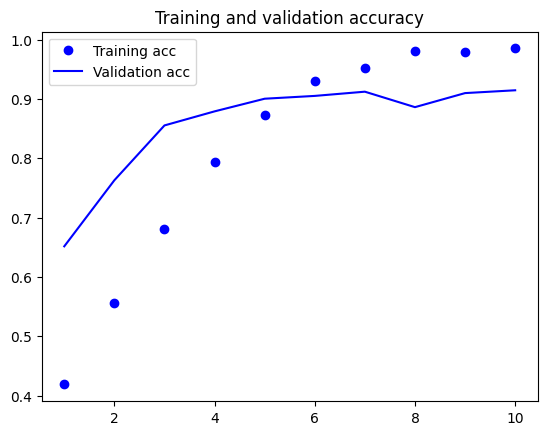

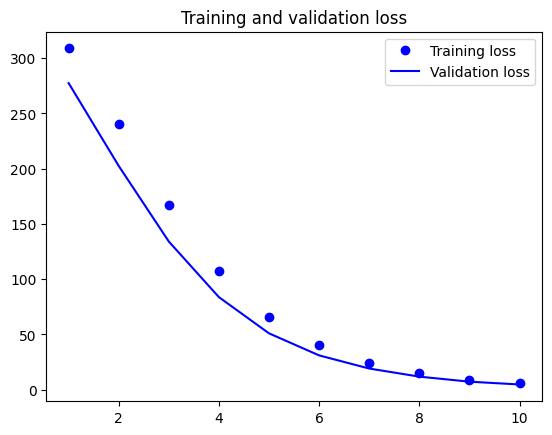

In [ ]:
# Plot performance metrics
import matplotlib.pyplot as plt

# Retrieve accuracy and loss from the model's history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs to use in the plot
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
# Save the model
bn_model.save('bn_model.h6')

# Load test images
images_test = os.listdir("/content/drive/MyDrive/documentos/vinyl genre class/data/For thesis/data/For thesis/Testing")

# Initialize a dataframe to store test results
df_test = pd.DataFrame(columns=['category', 'name'])
categories = ['electronic','rock','hiphop']

# Loop through all test images, predict their category and append results to the dataframe
for image in images_test:
     if image.endswith(".jpg") is True or image.endswith(".jpeg") is True:
            img = tf.keras.utils.load_img (
                f"/content/drive/MyDrive/documentos/vinyl genre class/data/For thesis/data/For thesis/Testing/{image}", target_size=(300, 300)
            )
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)
            img_array /= 255.

            preds = bn_model.predict(img_array)
            score = preds[0]
            max_indexes = np.argmax(score)

            df_test = pd.concat([df_test, pd.DataFrame({'category': [categories[max_indexes]], 'name': [image]})], ignore_index=True)
            print(f"{image} is {categories[max_indexes]}")

# Save test results to a CSV file
df_test.to_csv('results_bn_new.csv', header=True)

2023-09-01 16:04:57.796418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-09-01 16:04:57.804285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-09-01 16:04:57.812395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-09-01 16:05

INFO:tensorflow:Assets written to: bn_model.h6/assets


INFO:tensorflow:Assets written to: bn_model.h6/assets


1/1 [==============================] - 2s 2s/step
image_2305.jpeg is hiphop
1/1 [==============================] - 0s 100ms/step
image_1755.jpeg is electronic
1/1 [==============================] - 0s 100ms/step
image_2368.jpeg is hiphop
1/1 [==============================] - 0s 100ms/step
image_1803.jpeg is electronic
1/1 [==============================] - 0s 102ms/step
image_2410.jpeg is hiphop
1/1 [==============================] - 0s 100ms/step
image_986.jpg is electronic
1/1 [==============================] - 0s 100ms/step
image_2387.jpeg is rock
1/1 [==============================] - 0s 99ms/step
image_1764.jpeg is electronic
1/1 [==============================] - 0s 100ms/step
image_2910.jpeg is rock
1/1 [==============================] - 0s 102ms/step
image_981.jpg is rock
1/1 [==============================] - 0s 99ms/step
image_1737.jpeg is electronic
1/1 [==============================] - 0s 102ms/step
image_1798.jpeg is electronic
1/1 [==============================] - 0s 9